In [ ]:
# prompt: load drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: install catboost

!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/summer_project/rohlik-orders-forecasting-challenge/train.csv",index_col='id')
test = pd.read_csv("/content/drive/MyDrive/summer_project/rohlik-orders-forecasting-challenge/test.csv",index_col='id')
train_calendar = pd.read_csv("/content/drive/MyDrive/summer_project/rohlik-orders-forecasting-challenge/train_calendar.csv")
test_calendar = pd.read_csv("/content/drive/MyDrive/summer_project/rohlik-orders-forecasting-challenge/test_calendar.csv")
sub = pd.read_csv("/content/drive/MyDrive/summer_project/rohlik-orders-forecasting-challenge/solution_example.csv")

In [ ]:
train =  train[list(train.columns.intersection(test.columns)) + ['orders']]
train_calendar =  train_calendar[list(train_calendar.columns.intersection(test_calendar.columns))]
print("Train Shape:", train.shape)
print("Train calendar Shape:", train_calendar.shape)

Train Shape: (7340, 8)
Train calendar Shape: (13307, 7)


In [ ]:
df = train.copy()
# Convert the object column to datetime
df['date'] = pd.to_datetime(df['date'])
# Extract day, month, and year into separate columns
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek
#df['dayofmonth'] = df['date'].dt.day
df['dayofyear'] = df['date'].dt.dayofyear
train = df.copy()

df = test.copy()
# Convert the object column to datetime
df['date'] = pd.to_datetime(df['date'])
# Extract day, month, and year into separate columns
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek
#df['dayofmonth'] = df['date'].dt.day
df['dayofyear'] = df['date'].dt.dayofyear
test = df.copy()

train['holiday_name'] = train['holiday_name'].fillna('None')
test['holiday_name'] = test['holiday_name'].fillna('None')

df.describe(include= 'object')

,warehouse,holiday_name
count,397,17
unique,7,5
top,Prague_1,Good Friday
freq,61,4


In [ ]:
train = train.reset_index()
test = test.reset_index()
# Removing Id From Train Test
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

In [ ]:
df_tr =  train.copy()
df_ts =  test.copy()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to 'warehouse' and 'holiday_name' columns in the train dataset
#df_tr['warehouse'] = label_encoder.fit_transform(df_tr['warehouse'])
df_tr['holiday_name'] = label_encoder.fit_transform(df_tr['holiday_name'])

# Apply label encoding to 'warehouse' and 'holiday_name' columns in the test dataset
#df_ts['warehouse'] = label_encoder.fit_transform(df_ts['warehouse'])
df_ts['holiday_name'] = label_encoder.fit_transform(df_ts['holiday_name'])
# there is only one cat-column - warehouse
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit the encoder on the train data and transform both train and test data
encoded_train = one_hot_encoder.fit_transform(train[['warehouse']])
encoded_test = one_hot_encoder.transform(test[['warehouse']])

encoded_train_df = pd.DataFrame(encoded_train, columns=one_hot_encoder.get_feature_names_out(['warehouse']))
encoded_test_df = pd.DataFrame(encoded_test, columns=one_hot_encoder.get_feature_names_out(['warehouse']))

df_tr = pd.concat([df_tr, encoded_train_df], axis=1)
df_ts= pd.concat([df_ts, encoded_test_df], axis=1)

#print("Train DataFrame:\n", df_tr)
#print("\nTest DataFrame:\n", df_ts)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
def cyclic_encode_date(df):
    pi = np.pi

    # Normalize the values
    #df['year_norm'] = df['year'] / df['year'].max()
    #df['month_norm'] = df['month'] / 12.0
    #df['day_norm'] = df['day'] / 31.0
    #df['dayofweek_norm'] = df['dayofweek'] / 7.0
    #df['dayofmonth_norm'] = df['dayofmonth'] / 31.0
    #df['dayofyear_norm'] = df['dayofyear'] / 365.0

    # Apply sine and cosine transformations
    #df['year_sin'] = np.sin(2 * pi * df['year_norm'])
    #df['year_cos'] = np.cos(2 * pi * df['year_norm'])
    df['month_sin'] = np.sin(2 * pi * (df['month'] / 12.0))
    #df['month_cos'] = np.cos(2 * pi * df['month_norm'])
    df['day_sin'] = np.sin(2 * pi * (df['day'] / 31.0))
    df['day_cos'] = np.cos(2 * pi * (df['day'] / 31.0))
    df['dayofweek_sin'] = np.sin(2 * pi * (df['dayofweek'] / 7.0))
    df['dayofweek_cos'] = np.cos(2 * pi * (df['dayofweek'] / 7.0))
    #df['dayofmonth_sin'] = np.sin(2 * pi * df['dayofmonth_norm'])
    #df['dayofmonth_cos'] = np.cos(2 * pi * df['dayofmonth_norm'])
    df['dayofyear_sin'] = np.sin(2 * pi * (df['dayofyear'] / 365.0))
    df['dayofyear_cos'] = np.cos(2 * pi * (df['dayofyear'] / 365.0))
    df.drop(columns=["school_holidays","warehouse_Prague_2","winter_school_holidays"],inplace=True)

    return df

    # Drop the normalized columns if no longer needed
    #df.drop(columns=['year_norm', 'month_norm', 'day_norm','day'], inplace=True)

    #return df

# Apply cyclic encoding to your DataFrame
df_tr = cyclic_encode_date(df_tr)
df_ts = cyclic_encode_date(df_ts)

#print("Train DataFrame:\n", df_tr)
#print("\nTest DataFrame:\n", df_ts)


In [ ]:
df_tr.columns.shape

(24,)

In [ ]:
# Removing Date From Train and Test
df_tr.drop(['date','warehouse'], axis=1,inplace=True)
df_ts.drop(['date','warehouse'], axis=1,inplace=True)

# Spliting the data into features and target
X = df_tr.drop('orders', axis=1)
y = df_tr['orders']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5872, 21), (1468, 21), (5872,), (1468,))

In [ ]:
# Train the model
model = LGBMRegressor(n_estimators=300)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 5872, number of used features: 21
[LightGBM] [Info] Start training from score 5512.430518


LGBMRegressor(n_estimators=300)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_absolute_percentage_error, r2_score
# Predict on the validation set
y_pred = model.predict(X_val)
# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_val, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)


mae = mean_absolute_error(y_val, y_pred)

# Compute MSE
mse = mean_squared_error(y_val, y_pred)

# Compute R²
r2 = r2_score(y_val, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Percentage Error (MAPE): 0.03737963715755071
Mean Absolute Error (MAE): 184.40624082568516
Mean Squared Error (MSE): 78413.22967455891
R-squared (R²): 0.983600628686583


In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=300)#**{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 240, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.9})
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:

# Predict on the validation set
y_pred = xgb_model.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_val, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val, y_pred)

# Compute MSE
mse = mean_squared_error(y_val, y_pred)

# Compute R²
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Percentage Error (MAPE): 0.03766385471794026
Mean Absolute Error (MAE): 183.32483618525782
Mean Squared Error (MSE): 74681.95981207525
R-squared (R²): 0.9843809878198491


In [ ]:
rf = CatBoostRegressor(verbose=0)
rf.fit(X_train, y_train)

In [ ]:

# Predict on the validation set
y_pred = rf.predict(X_val)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_val, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_val, y_pred)

# Compute MSE
mse = mean_squared_error(y_val, y_pred)

# Compute R²
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Percentage Error (MAPE): 0.03679671182560051
Mean Absolute Error (MAE): 182.27085849575394
Mean Squared Error (MSE): 71038.35124506408
R-squared (R²): 0.9851430134379643


In [ ]:
model = LGBMRegressor(n_estimators=300).fit(X,y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 21
[LightGBM] [Info] Start training from score 5535.443869


In [ ]:
xgb_model = XGBRegressor(n_estimators=300).fit(X,y)

[ 3 14 16 15 19 17  6  9  0  4  1 13  7 18 20  5  2 11  8 10 12]


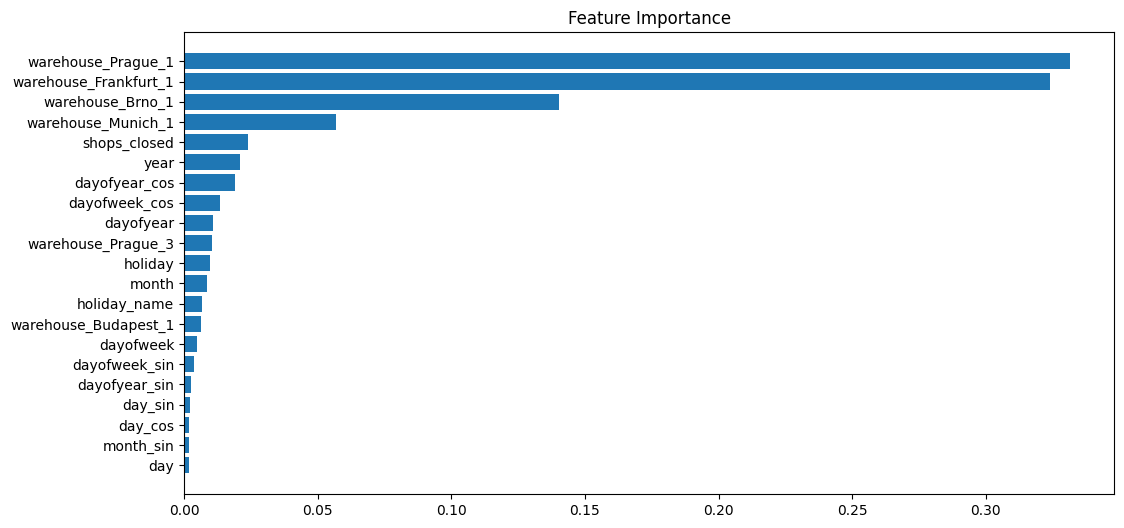

In [ ]:

feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')
print(sorted_idx)

Text(0.5, 1.0, 'Permutation Importance')

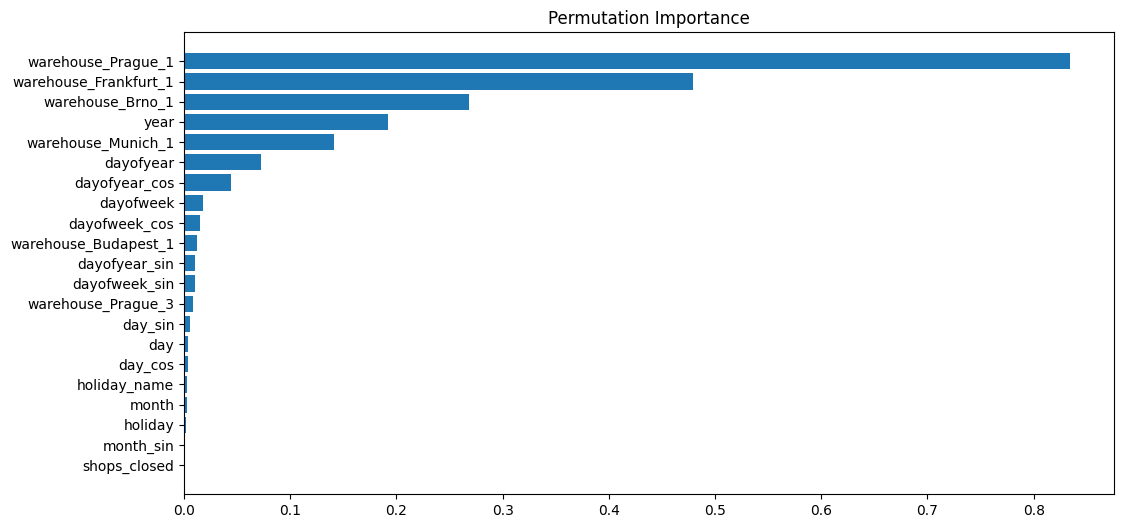

In [ ]:

perm_importance = permutation_importance(xgb_model, np.ascontiguousarray(X_val), y_val, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Permutation Importance')


In [ ]:
cat_model = CatBoostRegressor(verbose=0).fit(X,y)

Text(0.5, 1.0, 'Feature Importance')

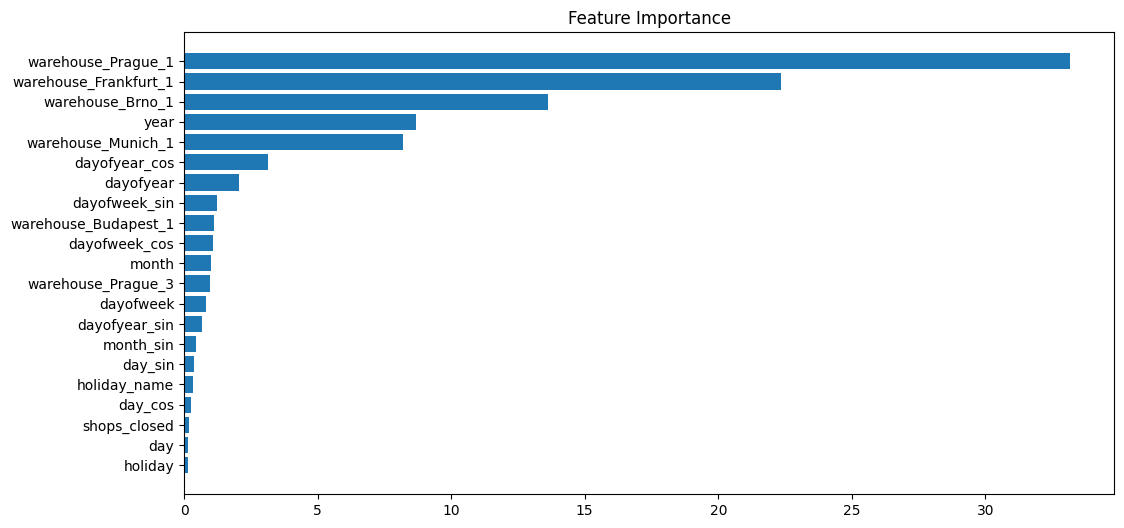

In [ ]:

feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Permutation Importance')

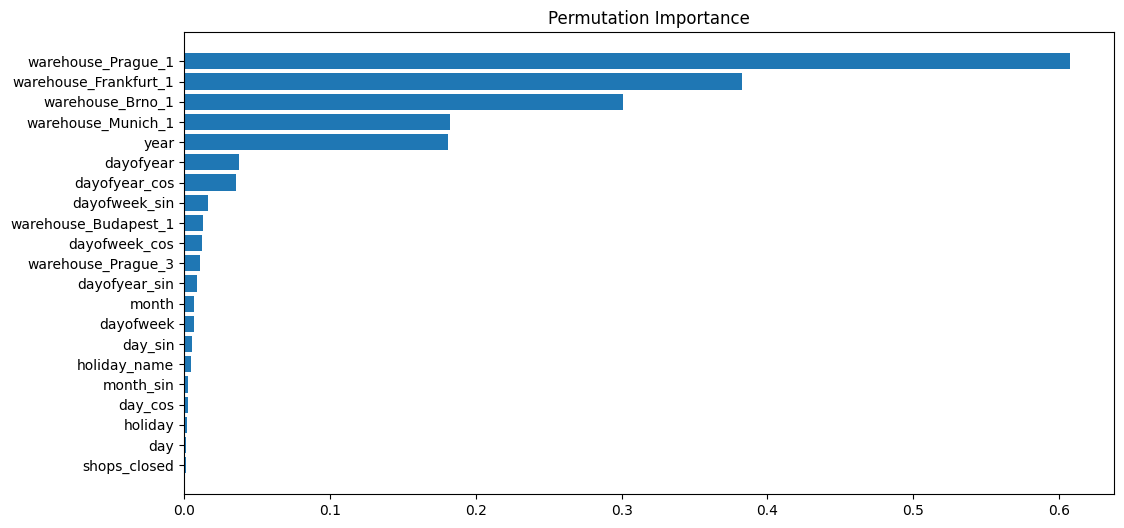

In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(cat_model, X_val, y_val, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Permutation Importance')


In [ ]:
output = model.predict(df_ts)*.33+xgb_model.predict(df_ts)*.34+cat_model.predict(df_ts)*.33

In [ ]:
output_p = np.round(output).astype(int)
sub['orders'] = output
#sub.to_csv('submission11.csv',index=False)
sub

,id,orders
0,Prague_1_2024-03-16,10524.715752
1,Prague_1_2024-03-17,10275.675145
2,Prague_1_2024-03-18,9477.884725
3,Prague_1_2024-03-19,9356.349339
4,Prague_1_2024-03-20,9212.842224
...,...,...
392,Budapest_1_2024-05-11,7223.446232
393,Budapest_1_2024-05-12,6675.943851
394,Budapest_1_2024-05-13,6689.060517
395,Budapest_1_2024-05-14,6675.159470
